#### Notebook for performing analysis on X-CER experiments executed on IBM Quantum Platform Devices

##### **Things to Check and Remember Before Running This Notebook**
1. Make sure IBM Quantum token access is enabled.
2. Ensure all imports (`xcer_funcs` especially) are imported

In [1]:
##### Imports #####
# xcer_funcs contains functions for generating the X-CER circuits
# We also want to import the Qiskit IBM Provider
from xcer_funcs import generate_cer_circuits
from datalogger import DataLogger

from qiskit_ibm_runtime import QiskitRuntimeService

# Import numpy and trueq
import numpy as np
import trueq as tq

import datetime
import random

from xcer_funcs import *

import ast

from datetime import datetime, timedelta

from sklearn.mixture import GaussianMixture

from scipy.optimize import minimize
from functools import partial

Replace id with id of experiment folder


Replace backend with "ibm_rensselaer"

In [2]:
id = "2325"
service = QiskitRuntimeService(instance="ibm-q-ncsu/nc-state/noiseanderror")

backend = service.backend('ibm_torino')

dir = F"./devices/{backend.name}/{id}/"

dl = DataLogger(directory=dir, id=id)

cer_circuits = tq.load(F"{dir}/executed_circuits.tq")

experiments_info = dl.read_data()
rep_len_tuples = ast.literal_eval(experiments_info["rep_len_tuples"])



In [3]:
# ancilla_indices = {
#     "ibmq_guadalupe": 10,
#     "ibm_cairo": 21,
#     "ibm_sherbrooke": 118,
#     "ibm_cusco": 2,
#     'ibm_rensselaer':2,
#     'ibm_kyiv': 2}
# cx_indices = {
#     "ibmq_guadalupe": [6, 7],
#     "ibm_cairo": [17, 18],
#     "ibm_sherbrooke": [100, 110],
#     "ibm_cusco": [0, 1],
#     'ibm_rensselaer':[0, 1],
#     'ibm_kyiv': [0, 1]}
# cer_circuits.update_keys(subsystems=((ancilla_indices[backend.name],),))

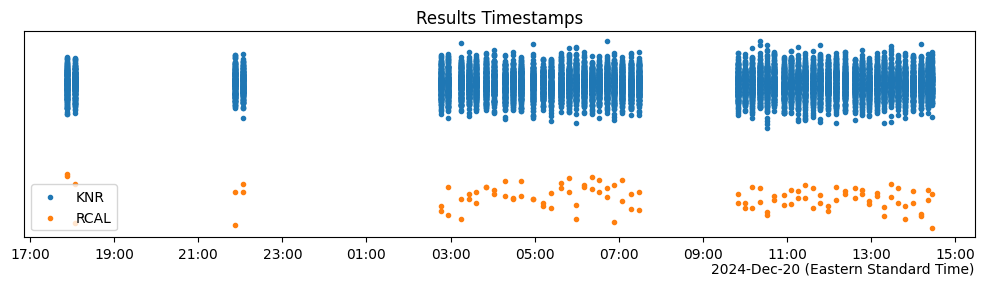

In [5]:
cer_circuits.plot.timestamps()

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_all_fidelity_vs_sequence_length(results_df, filename=None, file_format='pdf'):
    # Set the overall aesthetics for the presentation
    sns.set_context("talk")  # This increases the default font sizes for better visibility
    sns.set_theme(style="whitegrid", palette="deep")

    # Create the subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(25, 15), dpi=300)
    pauli2ax = {'X': ax1, 'Y': ax2, 'Z': ax3}

    # Define different color palettes for each subplot
    palettes = {
        'X': 'Blues',
        'Y': 'Greens',
        'Z': 'Reds'
    }
    pallete = sns.color_palette("tab20", n_colors=20)
    
    for pauli in ['X', 'Y', 'Z']:
        # Initialize the figure
        sns.despine(bottom=True, left=True)

        # Show each observation with a scatterplot using different palettes
        sns.stripplot(x="n_random_cycles", y="fidelity", hue="rep",
                      data=results_df[results_df['Pauli'] == pauli], dodge=0.5, alpha=.6, zorder=1, ax=pauli2ax[pauli],
                      palette=pallete)

        # Adjust labels and title sizes
        pauli2ax[pauli].set_ylabel(r'$f_'+pauli+'$', fontsize=24, fontweight='bold')
        if pauli == 'Z':
            pauli2ax[pauli].set_xlabel(r'Sequence length (m)', fontsize=20, fontweight='bold')
        else:
            pauli2ax[pauli].set_xlabel('')

        # Adjust tick sizes
        pauli2ax[pauli].tick_params(axis='both', which='major', labelsize=18, width=2)
        pauli2ax[pauli].tick_params(axis='both', which='minor', labelsize=16, width=1.5)

        # Set consistent grid lines for all subplots with darker color
        for axis in ['both']:
            pauli2ax[pauli].grid(True, which='major', axis=axis, linestyle='--', linewidth=0.7, color='gray', alpha=0.7)

        # Remove the individual legends
        pauli2ax[pauli].legend_.remove()

    # Add title to the figure
    fig.suptitle("Fidelity vs. Sequence Length for Different Pauli Fidelity Components", fontsize=28, fontweight='bold')

    # Collect handles and labels from all subplots
    handles, labels = [], []
    for ax in [ax1, ax2, ax3]:
        for handle, label in zip(*ax.get_legend_handles_labels()):
            if label not in labels:
                handles.append(handle)
                labels.append(label)

    # Add a single legend to the right of the first subplot
    ax1.legend(handles, labels, title="CX repetitions",
               handletextpad=0.5, columnspacing=1.5,
               loc="upper left", bbox_to_anchor=(1, 1), frameon=True, fontsize=18, title_fontsize=20, markerscale=3)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout to make space for the legend

    # Save plot if filename is provided
    if filename:
        plt.savefig(f"{filename}.{file_format}", format=file_format)

    # Show plot
    plt.show()

def generate_palette(num_colors, base_colors):
    return sns.color_palette(base_colors, num_colors)

def plot_fidelity_vs_sequence_length(data, model_df, pauli, sequence_lengths, cnot_reps, filename=None, file_format='pdf', minimized_value=None):
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    # Get the number of unique clusters and sort them
    unique_clusters = sorted(data['cluster'].unique())
    num_clusters = len(unique_clusters)
    print(unique_clusters)
    # Define base colors for stripplot and pointplot
    base_stripplot_colors = ['#aec7e8', '#98df8a', '#ffbb78']  # lighter blue, lighter green, lighter orange
    # base_pointplot_colors = ['#1f77b4', '#2ca02c', '#ff7f0e']  # blue, green, orange
    base_pointplot_colors = ['#2ca02c','#1f77b4','#ff7f0e']   
    # base_pointplot_colors = ['#ff7f0e','#1f77b4','#2ca02c']
    # Generate color palettes based on the number of clusters
    stripplot_palette = generate_palette(num_clusters, base_stripplot_colors)
    pointplot_palette = generate_palette(num_clusters, base_pointplot_colors)

    # Create a dictionary mapping clusters to colors
    stripplot_palette_dict = {cluster: stripplot_palette[i % num_clusters] for i, cluster in enumerate(unique_clusters)}
    pointplot_palette_dict = {cluster: pointplot_palette[i % num_clusters] for i, cluster in enumerate(unique_clusters)}
    print(stripplot_palette_dict)
    # Plot the stripplot without a legend
    sns.stripplot(x="n_random_cycles", y="fidelity", hue="cluster",
                  data=data[(data['Pauli'] == pauli) & (data['n_random_cycles'] == sequence_lengths) & (data["rep"] == cnot_reps)], 
                  zorder=1, legend=False, palette=stripplot_palette_dict)

    # Plot the model df with a legend
    sns.pointplot(x="n_random_cycles", y="fidelity", hue="cluster",
                  data=model_df,
                  join=False, palette=pointplot_palette_dict,
                  markers="*", scale=1.15, errorbar=None, ax=ax)

    ax.set_ylabel(r'$f_'+pauli+'$', fontsize=16)
    ax.set_xlabel(r'Sequence length (m)', fontsize=16)

    # Add a title
    title = f"Fidelity vs. Sequence Length for $f_{{{pauli}}}$, {cnot_reps} repetitions"
    plt.title(title, fontsize=18)

    # Display minimized value as text in the plot
    if minimized_value is not None:
        textstr = f"Minimized angle: {minimized_value:.4f}"
        # Place the text in the upper left corner of the plot
        ax.text(0.60, 0.05, textstr, transform=ax.transAxes, fontsize=14,
                verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5))

    # Create custom legend
    handles, labels = ax.get_legend_handles_labels()
    custom_labels = [f"= {model_df.iloc[i]['fidelity']:.4f}" for i in range(len(model_df))]
    ax.legend(handles, custom_labels, title="Cluster Height")

    # Save plot if filename is provided
    if filename:
        plt.savefig(f"{filename}.{file_format}", format=file_format)

    # Show plot
    plt.show()

# Example usage
# plot_fidelity_vs_sequence_length(data, model_df, 'X', sequence_lengths, cnot_reps, minimized_value=0.1234, filename='fidelity_plot', file_format='png')

In [5]:
qubit_index = 2
results_df = extract_results_dataframe(cer_circuits, rep_len_tuples, qubit_index=qubit_index)
avg_df = extract_avg_dataframe(results_df, rep_len_tuples, confidence=0.682)

         (C:\Users\zpparks\AppData\Local\Temp\ipykernel_31008\2491383499.py:26)
         (C:\Users\zpparks\AppData\Local\Temp\ipykernel_31008\2491383499.py:26)
         (C:\Users\zpparks\AppData\Local\Temp\ipykernel_31008\2491383499.py:26)


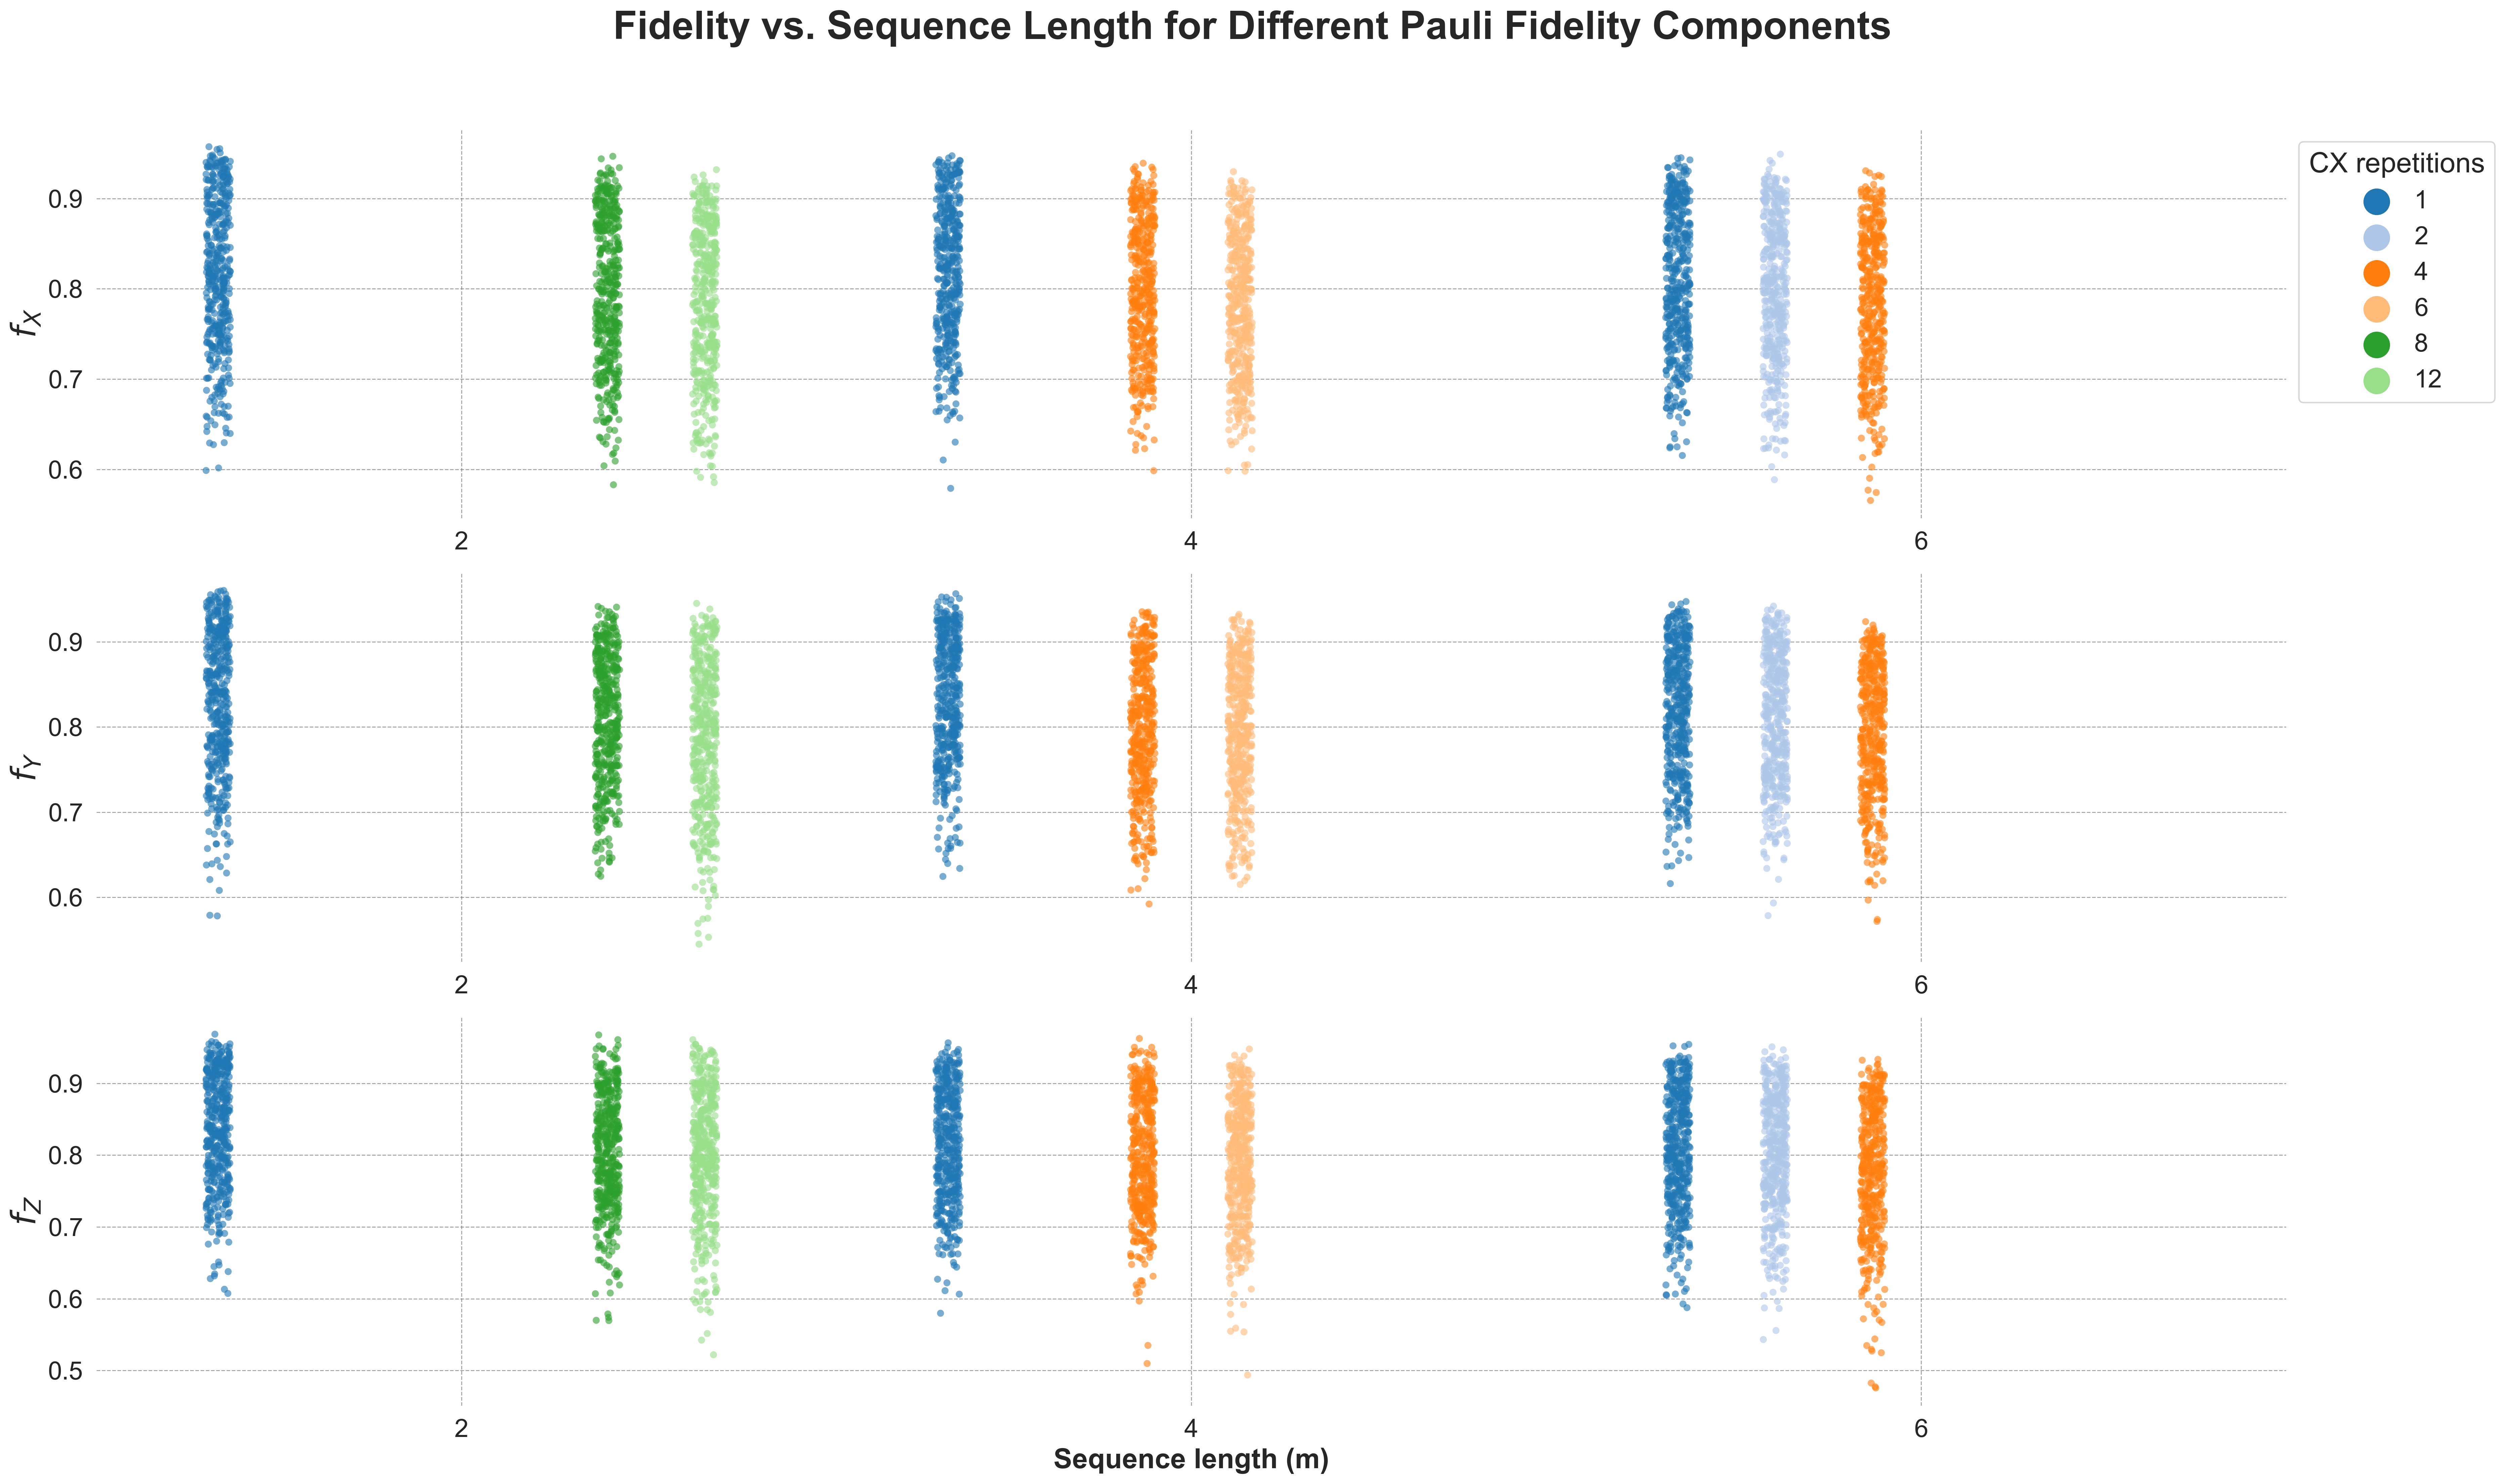

In [11]:
plot_all_fidelity_vs_sequence_length(results_df, filename=f"{dir}/all_fidelity_vs_sequence_length", file_format='pdf')

In [13]:

# model for fidelity - takes in angle, radius, and number of clusters
def fidelity_model(angle, radius, no_of_clusters):
    cluster_heights = []
    for cluster in range(no_of_clusters):
        cluster_heights.append(radius*np.cos(angle*np.pi/180*cluster))
    return np.array(cluster_heights) #<-- example  [0.8,0.7,-0.2,-0.5] (centers of clusters) the len of this should be no_of_clusters

def assign_cluster(point, clusters):
    for cluster_label, cluster_points in clusters.items():
        if point in cluster_points:
            # print(point, cluster_label)
            return cluster_label
    return 'No Cluster'

def chi_sq(x, fid_flat):
    sum = 0
    for pt in fid_flat:
        sum += np.min((fidelity_model(x[0], x[1], len(clusters.keys()))-pt)**2)
    return sum

In [14]:
pauli = 'X'
cnot_reps = 6
sequence_lengths = 4

# Estimate the number of clusters (you might need to adjust this)
n_clusters = 3

results = results_df[(results_df['rep'] == cnot_reps) & (results_df['n_random_cycles'] == sequence_lengths) & (results_df['Pauli'] == pauli)]

fidelities = results['fidelity'].values.reshape((450, 1))
fid_flat = fidelities.flatten()

# Use GMM to cluster the data
gmm_model = GaussianMixture(n_components=n_clusters, covariance_type="diag")
gmm_model.fit(fidelities)
labels = gmm_model.predict(fidelities)

clusters = {}
for i, label in enumerate(labels):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(fidelities[i][0])

# Estimate the radius to be the average fidelity of the maximum cluster
radius = np.max([np.mean(clusters[key]) for key in clusters.keys()])

# Print (just to check)
print("Total number of clusters:", len(clusters.keys()))
print("Esimated radius:", radius)

chi_sq_partial = partial(chi_sq, fid_flat=fid_flat)

Total number of clusters: 3
Esimated radius: 0.8704289855072465


In [15]:
# make pd dataframe with gmm model means, columned as fidelity, rep, pauli, n_random_cycles
# mainly just curious about gmm_model means and how they compare to the fidelity model
sorted_indices = np.argsort(gmm_model.means_[:, 0])[::-1]
sorted_means = gmm_model.means_[sorted_indices]
gmm_df = pd.DataFrame(data=sorted_means, columns=['fidelity'])
gmm_df['n_random_cycles'] = sequence_lengths
gmm_df['rep'] = cnot_reps
gmm_df['Pauli'] = pauli

gmm_df['cluster'] = np.arange(len(sorted_means))

In [16]:
# model_points = fidelity_model(((rate_to_angle(np.array(error_df_full['coh_error'][2]))*2)*cnot_reps), radius, len(clusters.keys()))
model_points = fidelity_model(cnot_reps*6, radius, len(clusters.keys()))
model_points = np.sort(model_points)[::-1]
print(model_points)
# turn the model points into a pandas dataframe
# Each model point shares the columns n_random_cycles = sequence_lengths, Pauli = pauli, rep = cnot_reps
# The point values themselves are labeled fidelity
model_df = pd.DataFrame(data=model_points, columns=['fidelity'])
model_df['n_random_cycles'] = sequence_lengths
model_df['Pauli'] = pauli
model_df['rep'] = cnot_reps
# assign model points cluster labels
model_df['cluster'] = np.arange(len(clusters.keys()))

[0.87042899 0.70419184 0.26897735]


In [17]:
data = results
data['cluster'] = data['fidelity'].apply(lambda x: assign_cluster(x, clusters))

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
         (C:\Users\zpparks\AppData\Local\Temp\ipykernel_31008\1946776012.py:2)


In [18]:
fit = minimize(chi_sq_partial, [cnot_reps*6, radius],
               bounds = [(0,180), (0,1)], method="Nelder-Mead")


print("Minimized Radius:", fit.x[1])
min_radius = fit.x[1]
print("Minimized Angle:", rate_to_angle(angle_to_rate((fit.x[0]/cnot_reps)/2)))
min_angle = rate_to_angle(angle_to_rate((fit.x[0]/cnot_reps)/2))
print("Minimized rate:", angle_to_rate((fit.x[0]/cnot_reps)/2))
min_rate = angle_to_rate((fit.x[0]/cnot_reps)/2)

Minimized Radius: 0.8447408301552628
Minimized Angle: 2.652944374596847
Minimized rate: 0.0005359830206463349


In [19]:
fit_model_points = fidelity_model(fit.x[0], fit.x[1], len(clusters.keys()))
fit_model_points = np.sort(fit_model_points)[::-1]
print(fit_model_points)

fit_model_df = pd.DataFrame(data=fit_model_points, columns=['fidelity'])
fit_model_df['n_random_cycles'] = sequence_lengths
fit_model_df['Pauli'] = pauli
fit_model_df['rep'] = cnot_reps
fit_model_df['cluster'] = np.arange(len(clusters.keys()))


[0.84474083 0.71766442 0.37466801]


[0, 1, 2]
{0: (0.6823529411764706, 0.7803921568627451, 0.9098039215686274), 1: (0.596078431372549, 0.8745098039215686, 0.5411764705882353), 2: (1.0, 0.7333333333333333, 0.47058823529411764)}


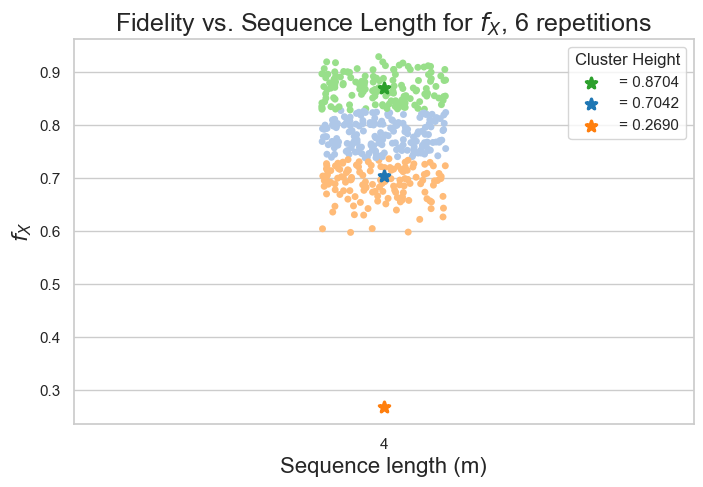

In [23]:
plot_fidelity_vs_sequence_length(data, model_df, pauli, sequence_lengths, cnot_reps, f'{dir}/{backend.name}_no_min_fidelity_plot', 'svg')

[0, 1, 2]
{0: (0.6823529411764706, 0.7803921568627451, 0.9098039215686274), 1: (0.596078431372549, 0.8745098039215686, 0.5411764705882353), 2: (1.0, 0.7333333333333333, 0.47058823529411764)}


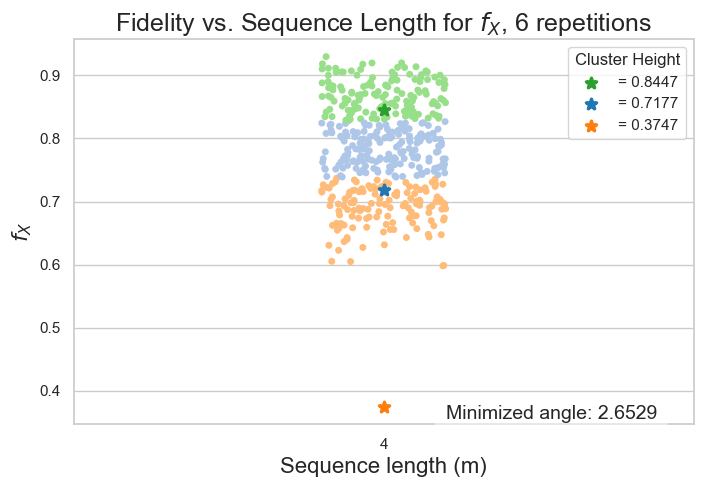

In [21]:
plot_fidelity_vs_sequence_length(data, fit_model_df, pauli, sequence_lengths, cnot_reps, f'{dir}/{backend.name}_min_fidelity_plot', 'svg', minimized_value=rate_to_angle(angle_to_rate((fit.x[0]/cnot_reps)/2)))

In [22]:
import numpy as np
from scipy.spatial.distance import cdist


# Calculate distance from each point to each model point
# 120 distances for each of the model points
distances = cdist(fidelities, fidelity_model(fit.x[0], fit.x[1], len(clusters.keys())).reshape((len(clusters.keys()),1)))

# Calculate residuals
# Find minimum distance columnwise, for each model point
residuals = np.min(distances, axis=1)

# Calculate total sum of squares
total_center = np.mean(results['fidelity'].values)
# find the total distances
total_distances = np.linalg.norm(results['fidelity'].values - total_center)
ss_tot = np.sum(total_distances**2)

# Calculate R^2
ss_res = np.sum(residuals**2)
r_squared = 1 - (ss_res / ss_tot)
print("Min Radius:", min_radius)
print("Min Angle:", min_angle)
print("Min Rate:", min_rate)
print("R^2:", r_squared)
print("SS_res:", ss_res)
print("SS_tot:", ss_tot)

Min Radius: 0.8447408301552628
Min Angle: 2.652944374596847
Min Rate: 0.0005359830206463349
R^2: 0.7111893139712208
SS_res: 0.7376935991311188
SS_tot: 2.554246206311111
